# Find Default Project

# Introduction

Fraudulent activities in credit card transactions are a significant concern for financial institutions and consumers. Detecting fraudulent transactions accurately is crucial to minimize financial losses and maintain trust in the banking system. In this project, I aim to develop a machine learning model to effectively identify fraudulent transactions based on historical credit card data.


# Imports

The code imports necessary libraries for data manipulation, visualization, model training, and evaluation. These include pandas for handling datasets, NumPy for numerical operations, matplotlib and seaborn for visualization, imbalanced-learn (imblearn) for handling imbalanced datasets, scikit-learn for machine learning tasks, scipy for statistical operations, and joblib for saving and loading models.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
import boto3
import sagemaker
import os
import warnings

warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Akshit\AppData\Local\sagemaker\sagemaker\config.yaml


# Data Preprocessing

## Loading the Dataset

he credit card dataset is loaded using pandas' read_csv() function. This dataset contains information about credit card transactions, including features like time, transaction amount, and various V1 to V28 features (possibly derived from PCA). The target variable is 'Class', which indicates whether a transaction is fraudulent (1) or not (0).


In [2]:
# Loading the credit card dataset
credit = pd.read_csv('creditcard.csv')

In [3]:
# Displaying the first few rows of the dataset
print("First few rows of the dataset:")
credit.head()

First few rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data types and missing values

The data types and missing values in the dataset are checked using the info() method. Fortunately, there are no missing values in any of the columns, and all features are numerical.

In [4]:
# Data types and missing values
print("\nCredit card Data types and missing values:")
credit.info()


Credit card Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20 

## Summary statistics of the numerical features

Summary statistics of the numerical features are displayed using the describe() method. This provides insights into the distribution and range of values for each feature. For example, the 'Time' feature ranges from 0 to 172792, and the 'Amount' feature ranges from 0 to 25691.16.


In [5]:
# Summary statistics
print("\nSummary statistics of numerical features:")
credit.describe()


Summary statistics of numerical features:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.759061e-12,-8.251130e-13,-9.654937e-13,8.321385e-13,1.649999e-13,4.248366e-13,-3.054600e-13,8.777971e-14,-1.179749e-12,...,-3.405756e-13,-5.723197e-13,-9.725856e-13,1.464150e-12,-6.987102e-13,-5.617874e-13,3.332082e-12,-3.518874e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Handling Missing Values

### Checking for Missing Values:

The code checks for missing values in the credit dataset using the isnull() method followed by sum() to count the missing values for each column.

### Displaying Columns with Missing Values:

If any missing values are found, the code prints the columns with missing values. In this case, there are no missing values in the dataset, as indicated by the empty Series. This step ensures data integrity by identifying and addressing missing values before proceeding with further analysis.


In [6]:
# Checking for missing values in train_data
credit_missing_values = credit.isnull().sum()
print("Columns with missing values:")
print(credit_missing_values[credit_missing_values > 0])

Columns with missing values:
Series([], dtype: int64)


# Exploratory Data Analysis (EDA)

## Distribution of Class


- The dataset contains a binary class variable 'Class', where:
   - Class 0 represents legitimate transactions.
   - Class 1 represents fraudulent transactions.
- Using Seaborn's `countplot()`, the code visualizes the distribution of the 'Class' variable.
- The x-axis represents the two classes: 0 (legitimate transactions) and 1 (fraudulent transactions), and the y-axis represents - the count of each class.
- This visualization helps understand the class distribution, which is crucial for building predictive models, especially for imbalanced datasets like credit card fraud detection.


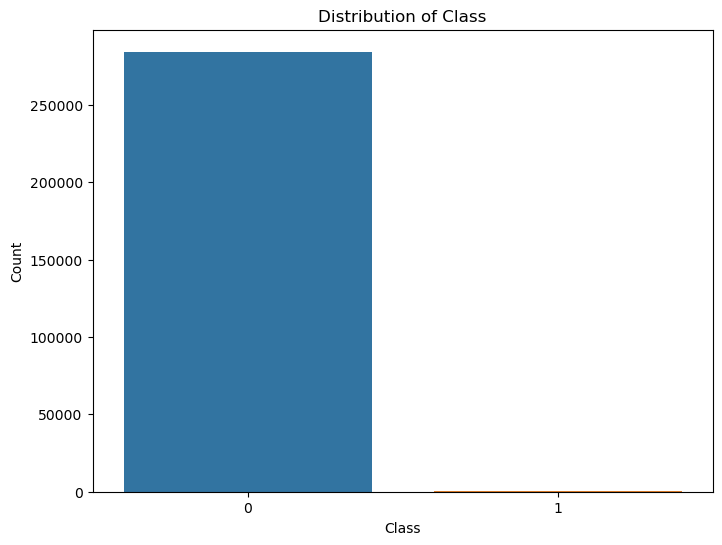

In [7]:
# Plot distribution of loan_status
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=credit)
plt.title('Distribution of Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Distribution of Time

- The 'Time' variable represents the time elapsed between transactions.
- Using Seaborn's `histplot()`, the code visualizes the distribution of the 'Time' variable.
- The x-axis represents the time values, and the y-axis represents the frequency of occurrence.
- The `bins` parameter controls the number of bins used to divide the data. In this case, it's set to 50.
- Setting `kde=True` adds a kernel density estimation plot overlaying the histogram, providing a smoothed representation of the distribution.
- Understanding the distribution of time between transactions can provide insights into any temporal patterns or anomalies in transaction behavior.


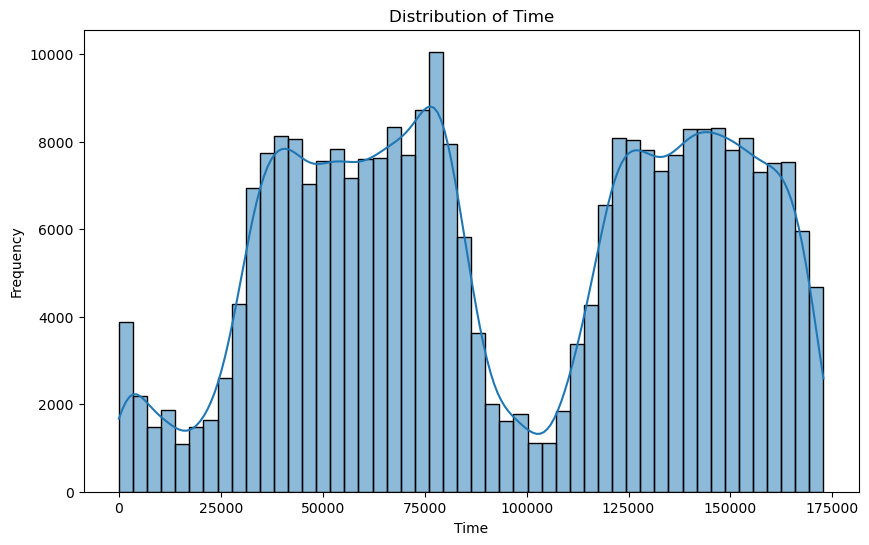

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(credit['Time'], bins=50, kde=True)
plt.title('Distribution of Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

## Line Plot of Amount


- The 'Amount' variable represents the transaction amount.
Using Seaborn's `lineplot()`, the code generates a line plot to visualize the changes in the 'Amount' variable over the - dataset's index.
- The x-axis represents the index of the dataset, which generally denotes the order of transactions.
- The y-axis represents the transaction amount.
- The line plot helps in understanding the trends or patterns in transaction amounts over the dataset's index.
- Adding grid lines (`plt.grid(True)`) enhances the readability of the plot by providing reference lines.


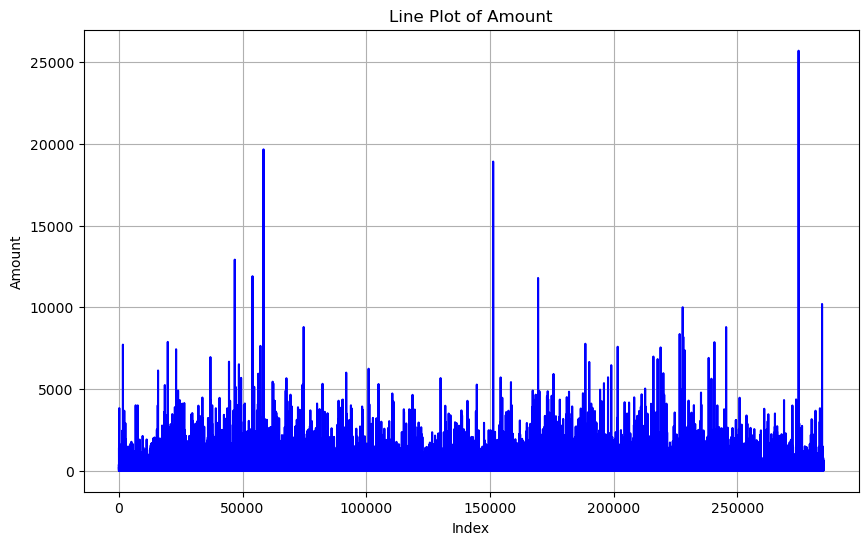

In [9]:
# Line plot for Amount
plt.figure(figsize=(10, 6))
sns.lineplot(data=credit['Amount'], color='blue')
plt.title('Line Plot of Amount')
plt.xlabel('Index')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

## Boxplot of Columns V1 to V28


- The columns V1 to V28 represent anonymized features derived from the credit card transactions.
- The code iterates through each column (excluding the first and last columns, which are assumed to be 'Time' and 'Class') and creates a boxplot for each.
- For each boxplot, the x-axis represents the 'Class' variable (0 for legitimate transactions, 1 for fraudulent transactions), and the y-axis represents the values of the respective feature column.
- The boxplot provides a visual representation of the distribution of each feature, showing the median, quartiles, and any outliers.
- Boxplots are commonly used to determine outliers, which are data points that significantly differ from the rest of the data.
- By comparing the boxplots between the two classes, it's possible to identify features that may have different distributions for fraudulent and legitimate transactions, as well as detect potential outliers.
- The subplot layout organizes the boxplots in a grid, with each subplot representing a different feature column.
- Adjustments to the layout (`plt.tight_layout()`) ensure proper spacing between subplots for improved readability.


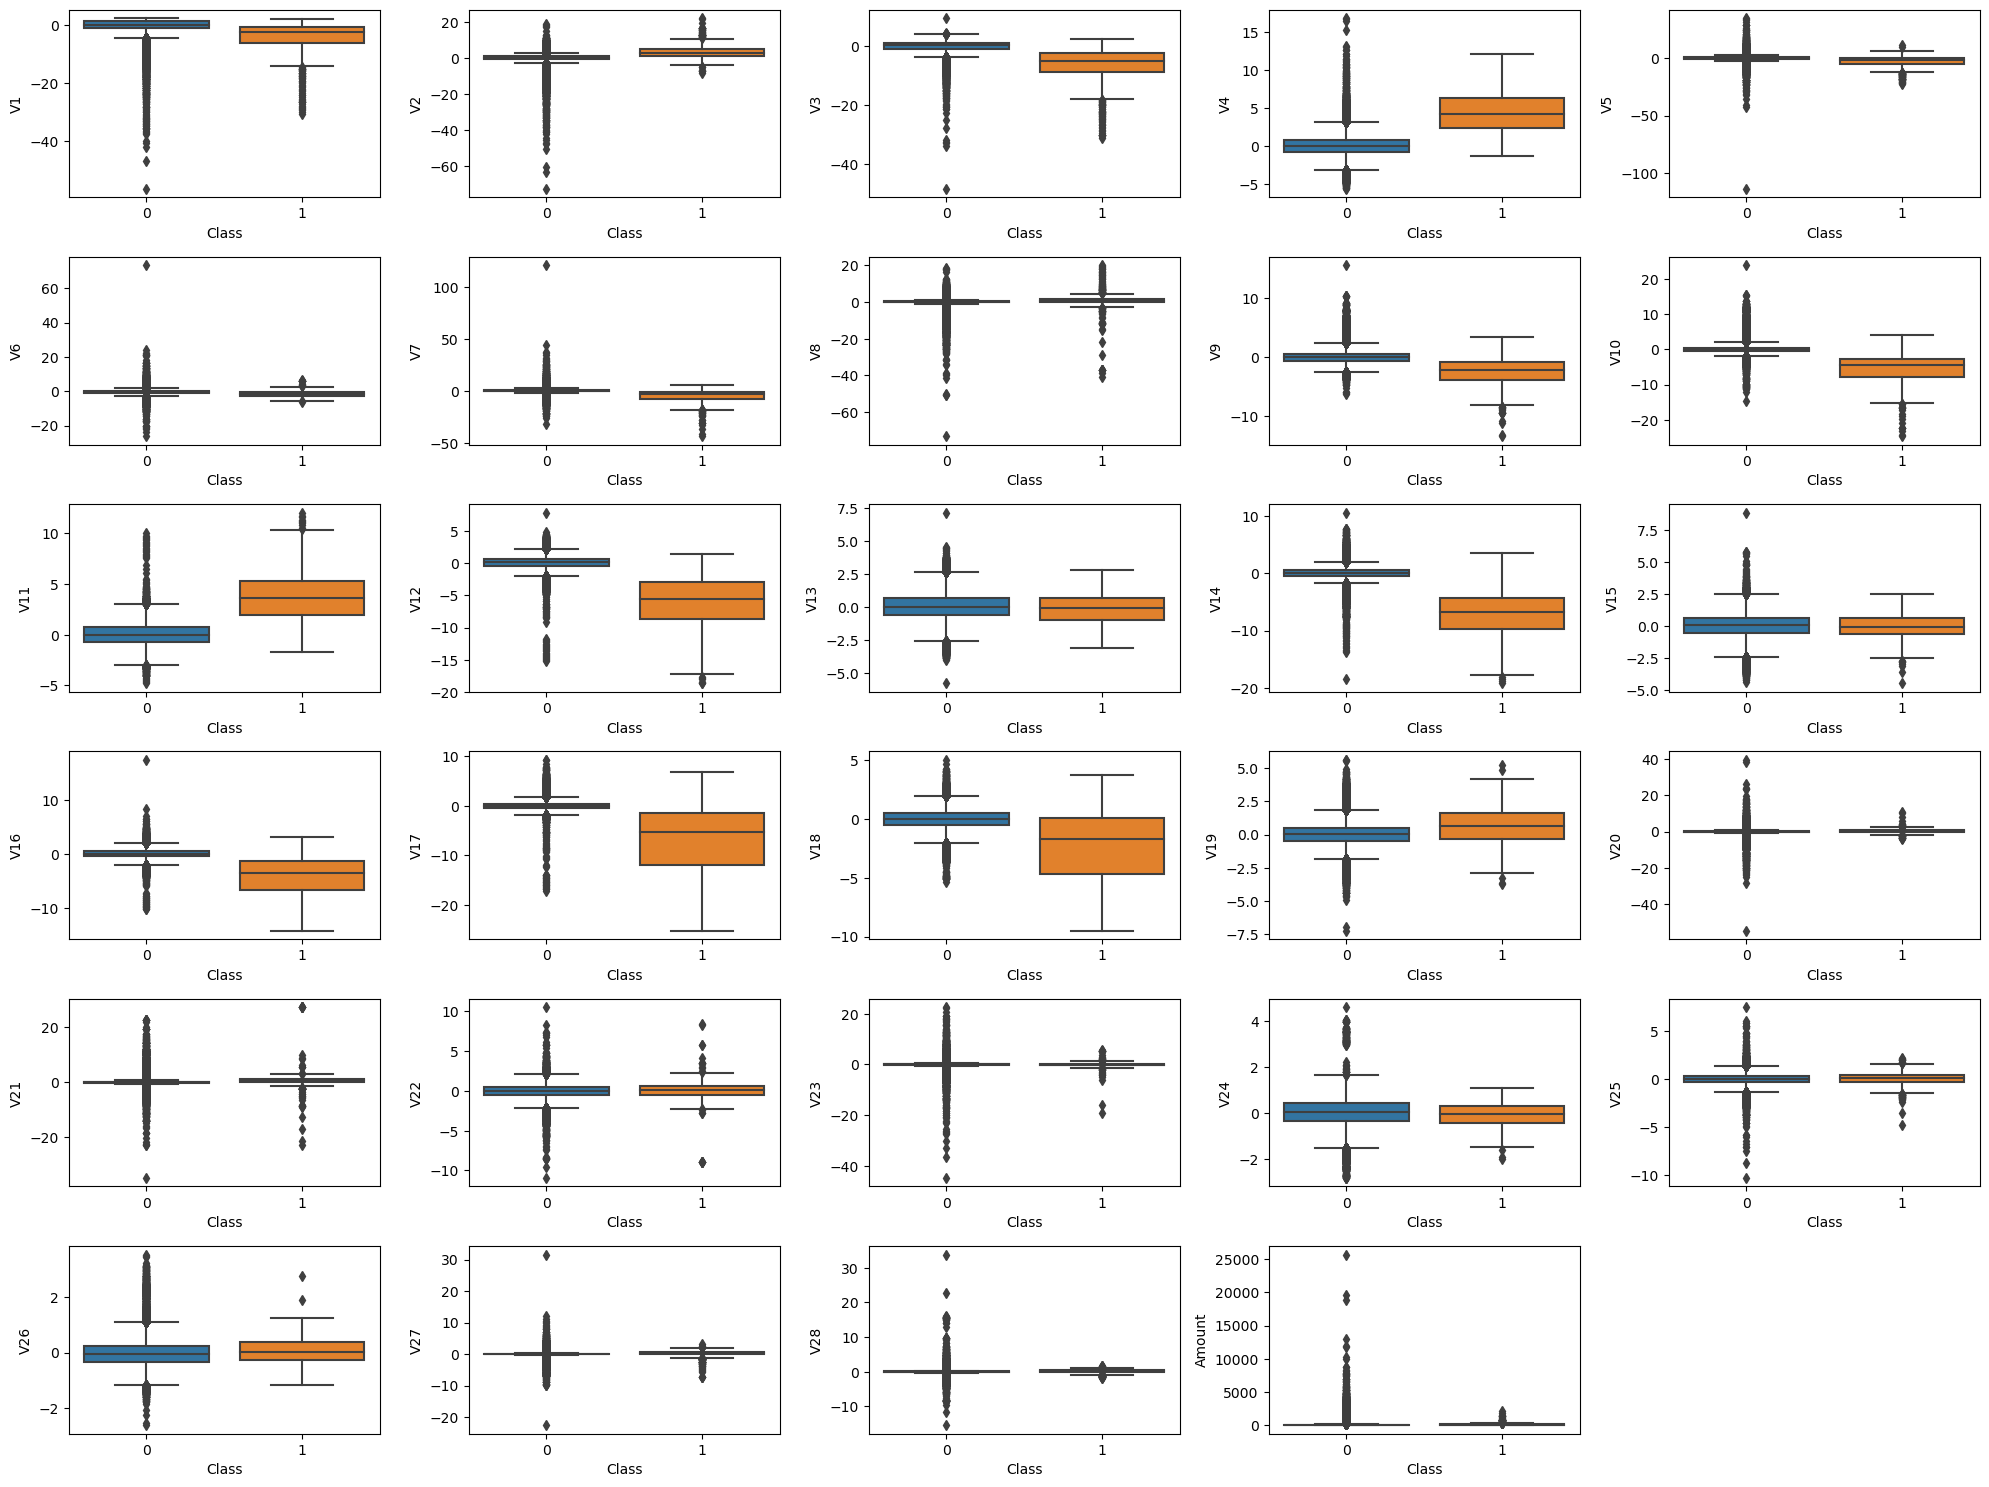

In [10]:
plt.figure(figsize=(20, 15))
plt.title('Boxplot of Columns V1 to V28')
for i, col in enumerate(credit.columns[1:-1]):
    plt.subplot(6, 5, i+1)
    sns.boxplot(x='Class', y=col, data=credit)
plt.tight_layout()
plt.show()

# Feature Engineering


## Handling Outliers Using Power Transformation

- Outliers in numerical data can skew statistical analyses and machine learning models. Power Transformation is one method used to mitigate the effects of outliers.
- The `PowerTransformer()` function from scikit-learn is used to perform Power Transformation on the selected columns.
- The `fit_transform()` method of the transformer is applied to the subset of the dataset containing columns 'V1' to 'Amount'.
- Power Transformation applies a power function to make the data more Gaussian-like, thereby reducing the impact of outliers.
- By transforming the data, it becomes more suitable for models that assume normality or require symmetric distributions.
- The transformed data replaces the original values in the specified columns of the dataset
- Handling outliers in this manner helps improve the robustness of subsequent analyses and modeling steps.


In [11]:
transformer = PowerTransformer()
credit.loc[:, 'V1':'Amount'] = transformer.fit_transform(credit.loc[:, 'V1':'Amount'])

## Scaling Features Using Min-Max Scaling

- Scaling features is a preprocessing step commonly performed to ensure all features have the same scale, which can improve the performance of certain machine learning algorithms.
- Min-Max Scaling is a method used to transform features by scaling them to a specified range, typically between 0 and 1.
- The `MinMaxScaler()` function from scikit-learn is used to perform Min-Max Scaling.
- The `fit_transform()` method of the scaler is applied to the subset of the dataset containing columns 'V1' to 'Amount'.
- Min-Max Scaling preserves the shape of the original distribution while ensuring that all feature values are within the specified range. 
- By scaling the features, helps prevent features with larger scales from dominating the modeling process and makes the algorithm more numerically stable.
- The scaled feature values replace the original values in the specified columns of the dataset.
- Applying Min-Max Scaling prepares the data for modeling and analysis, ensuring that each feature contributes proportionately to the learning process.


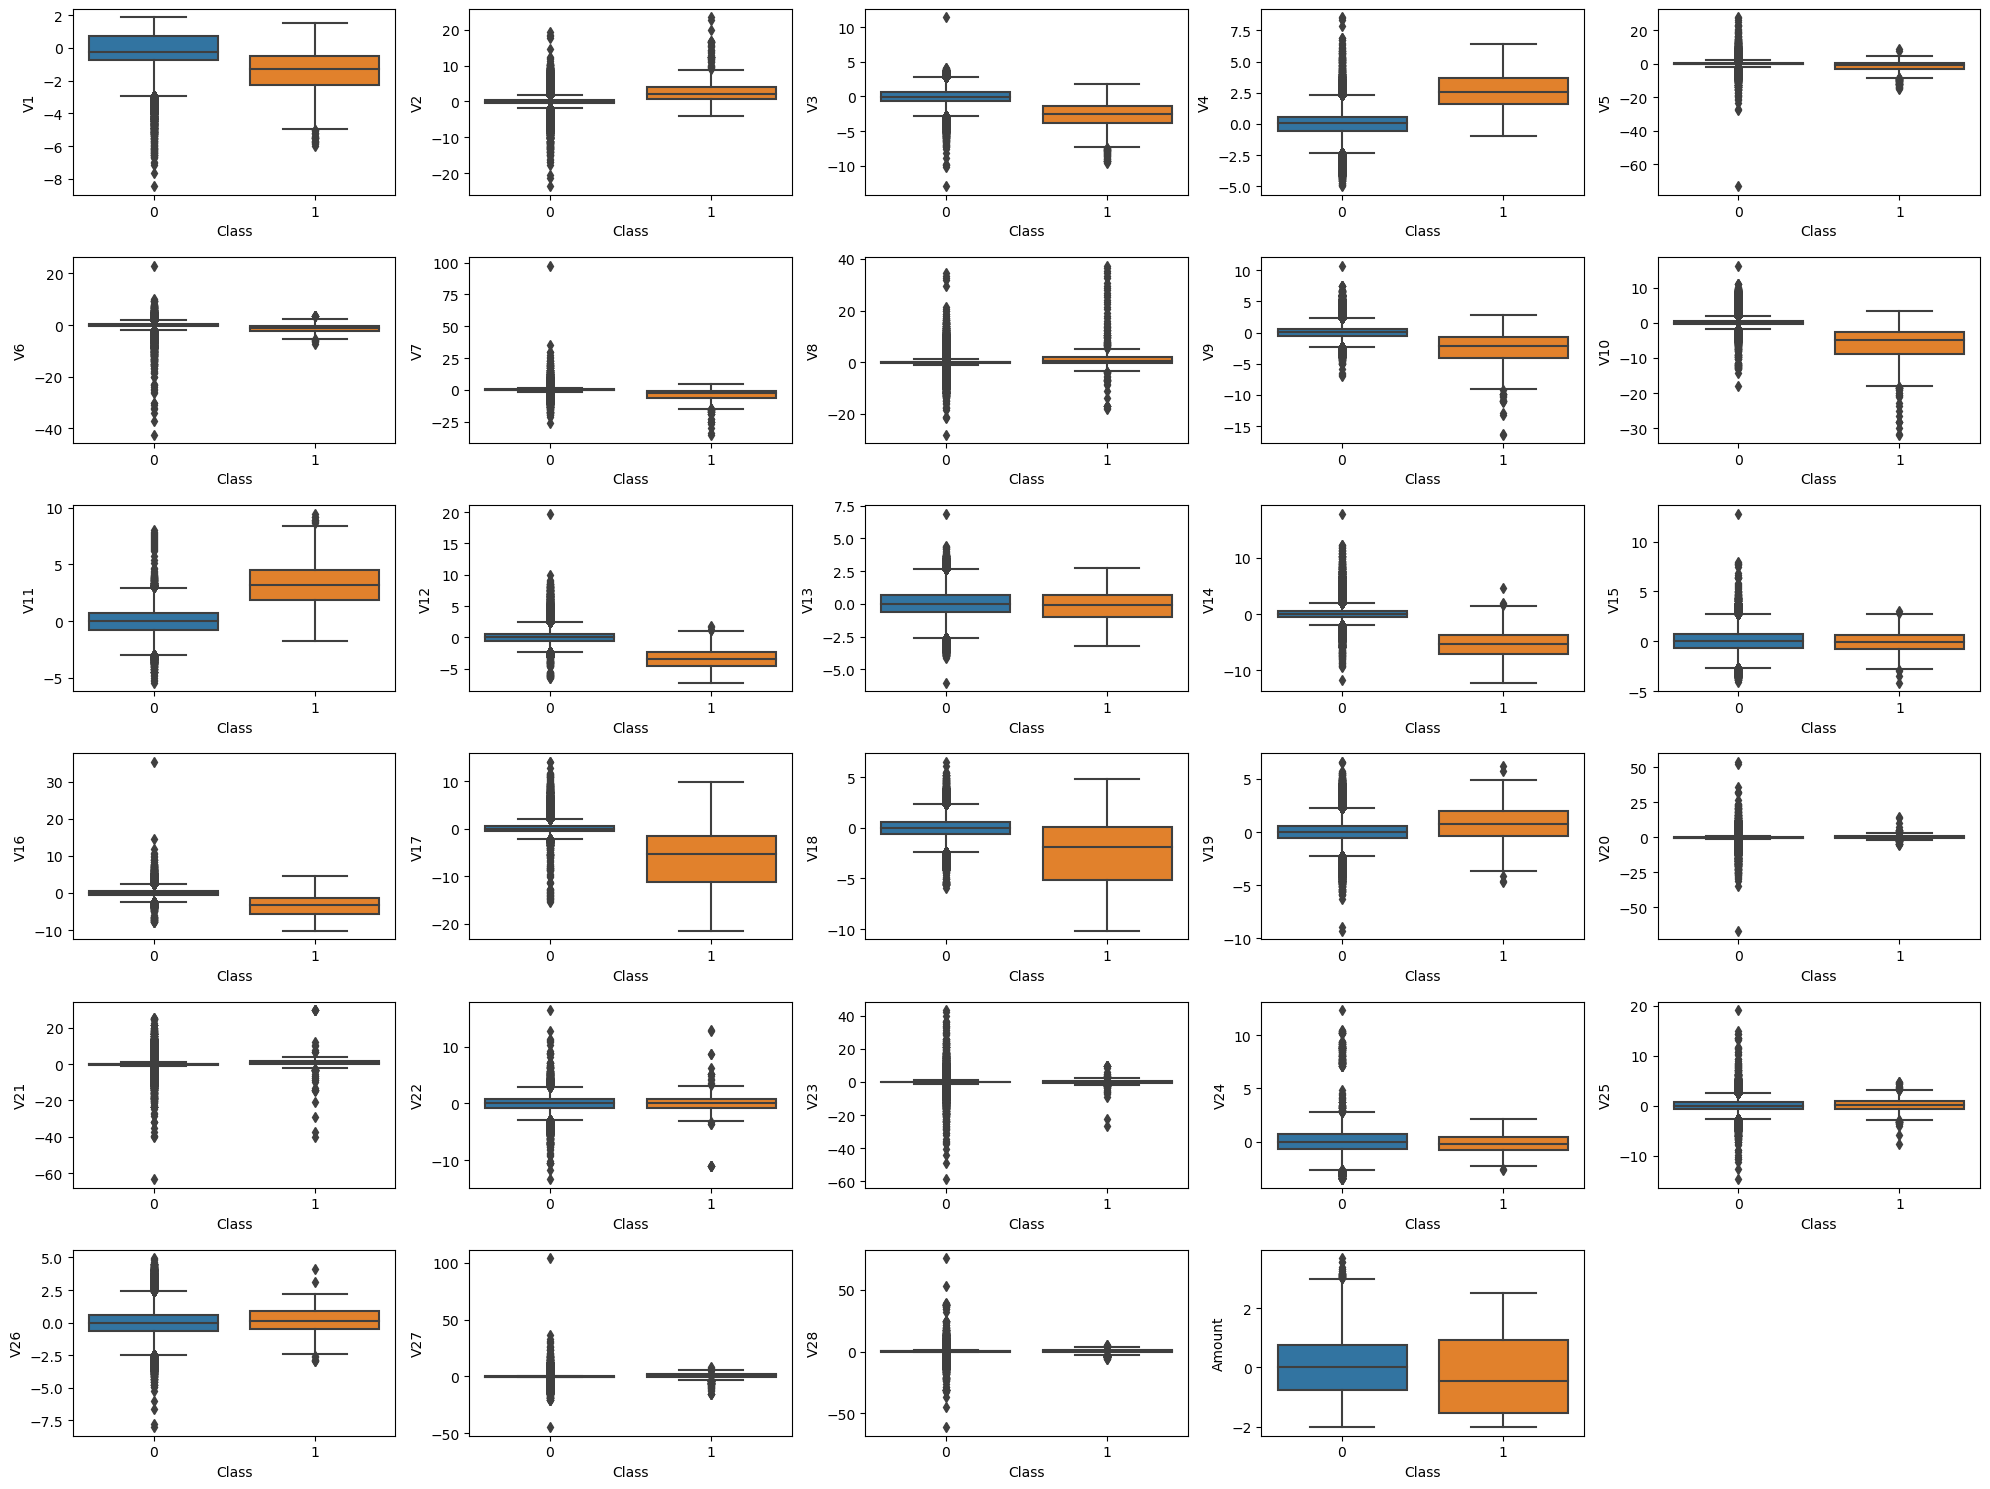

In [12]:
plt.figure(figsize=(20, 15))
plt.title('Boxplot of Columns V1 to V28 - Outliers Removed')
for i, col in enumerate(credit.columns[1:-1]):
    plt.subplot(6, 5, i+1)
    sns.boxplot(x='Class', y=col, data=credit)
plt.tight_layout()
plt.show()

In [13]:
scaler = MinMaxScaler()

credit.loc[:, 'V1':'Amount'] = scaler.fit_transform(credit.loc[:, 'V1':'Amount'])

In [14]:
credit.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,0.731869,0.500272,0.621413,0.442612,0.724608,0.655572,0.266075,0.429073,0.618089,...,0.680905,0.460318,0.573236,0.223032,0.440056,0.594100,0.302563,0.447695,0.550690,0
1,0.0,0.879919,0.505036,0.530978,0.398695,0.727466,0.649272,0.264137,0.428865,0.597244,...,0.677772,0.418247,0.576600,0.182041,0.442324,0.646331,0.300146,0.448504,0.155526,0
2,1.0,0.731925,0.484567,0.588907,0.395295,0.723434,0.668703,0.269433,0.431395,0.550405,...,0.684840,0.483958,0.589824,0.150887,0.414389,0.602889,0.299367,0.446816,0.639354,0
3,1.0,0.747529,0.498761,0.589714,0.327248,0.726959,0.663559,0.266063,0.433484,0.555355,...,0.679553,0.447547,0.571981,0.111742,0.471619,0.588235,0.301357,0.449556,0.531963,0
4,2.0,0.739718,0.514309,0.579880,0.396455,0.724117,0.651429,0.268225,0.423697,0.632446,...,0.681038,0.485247,0.572811,0.231247,0.421043,0.700378,0.304034,0.452974,0.475782,0
5,2.0,0.771758,0.515620,0.564186,0.366778,0.730084,0.649920,0.267515,0.431596,0.586063,...,0.678039,0.421780,0.574566,0.179095,0.419567,0.643235,0.304627,0.449995,0.182624,0
6,4.0,0.883119,0.503241,0.527370,0.434600,0.728419,0.653470,0.264585,0.428806,0.621344,...,0.678655,0.434856,0.572549,0.143253,0.478121,0.581840,0.300880,0.448288,0.210954,0
7,7.0,0.761511,0.523066,0.561708,0.348760,0.733949,0.655198,0.271437,0.384548,0.626122,...,0.708432,0.401528,0.575900,0.154269,0.409668,0.617815,0.280880,0.422337,0.421500,0
8,7.0,0.750552,0.505327,0.522854,0.361120,0.746749,0.684687,0.266869,0.441573,0.592414,...,0.680079,0.434975,0.571763,0.342606,0.454658,0.558142,0.300495,0.451363,0.504249,0
9,9.0,0.776087,0.518172,0.560602,0.363834,0.730655,0.647192,0.268582,0.428629,0.579920,...,0.677450,0.418467,0.573074,0.177833,0.428651,0.641407,0.304495,0.450040,0.182869,0


# Splitting Dataset





## Separating Features and Target Variable


- In machine learning tasks, it's common to split the dataset into features (independent variables) and a target variable (dependent variable).
- The features represent the input data used to make predictions, while the target variable represents the output or the variable to be predicted.
- Here, `X` represents the features, and `y` represents the target variable.
- The `drop()` function is used to remove the 'Class' column from the dataset `credit`, and the result is assigned to `X`. This operation retains all other columns except the 'Class', effectively creating a dataset of features.
- The 'Class' column is assigned to `y`, representing the target variable that contains the class labels (0 for legitimate transactions and 1 for fraudulent transactions).
- Finally, the code prints the class distribution of the target variable in the training set using the `value_counts()` function, which counts the occurrences of each class label.


In [15]:
# Separating features and target variable for training set
X = credit.drop(columns=['Class'])
y = credit['Class']


# Checking for class distribution in the training set
print("Class distribution in the training set:")
print(y.value_counts())


Class distribution in the training set:
0    284315
1       492
Name: Class, dtype: int64


## Splitting Data into Training, Validation, and Testing Sets

- The `train_test_split` function from scikit-learn is used twice to split the data into training, validation, and testing sets.
- The initial split (`train_test_split(X, y, test_size=0.2, random_state=42)`) splits the data into training and combined validation/test sets. Here, 20% of the data is reserved for testing.
- The combined validation/test set is further split (`train_test_split(X_val_train, y_val_train, test_size=0.25, random_state=42)`) into separate validation and test sets. Here, 25% of the combined validation/test set is reserved for validation.
- As a result, the data is divided into:
  - `X_train` and `y_train`: Features and target variable for training.
  - `X_val` and `y_val`: Features and target variable for validation.
  - `X_test` and `y_test`: Features and target variable for testing.
- The `test_size` parameter controls the proportion of the data allocated for testing in the initial split. In this case, 20% of the data is allocated for testing, and the remaining 80% is used for training and validation.
- The `random_state` parameter ensures reproducibility by fixing the random seed used for the data split.

In [16]:
# Splitting the data into training and testing sets
X_val_train, X_test, y_val_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Splitting combined validation/test set into separate validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_val_train, y_val_train, test_size=0.25, random_state=42)

In [18]:
y_train.value_counts()

0    170567
1       316
Name: Class, dtype: int64

In [19]:
y_val.value_counts()

0    56884
1       78
Name: Class, dtype: int64

In [20]:
y_test.value_counts()

0    56864
1       98
Name: Class, dtype: int64

# Handling Imbalanced data

## Synthetic Minority Over-sampling Technique (SMOTE) for Class Imbalance

- Class imbalance occurs when one class (e.g., fraudulent transactions) is significantly underrepresented compared to another class (e.g., legitimate transactions) in the dataset.
- SMOTE is a popular technique used to mitigate class imbalance by generating synthetic samples for the minority class.
- First, an instance of the SMOTE class is initialized with a specified random state (for reproducibility).
- Then, the `fit_resample()` method of SMOTE is applied to the feature matrix `X_train` and the target vector `y_train`.
- This method generates synthetic samples for the minority class (fraudulent transactions) to balance the class distribution.
- The resulting `X_train` and `y_train` contain the oversampled feature matrix and target vector, respectively.
- Finally, the code prints the class distribution after oversampling using the `value_counts()` function on the target vector `y_resampled`, showing that the classes are now balanced.


In [21]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling on the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

# Checking the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train).value_counts())

Class distribution after oversampling:
0    170567
1    170567
Name: Class, dtype: int64


## Creating Final Training, Validation, and Testing Datasets


- The target variables `y_train`, `y_val`, and `y_test` are converted into Pandas Series objects, ensuring they have the same index as the corresponding feature sets.
- The `pd.Series()` function is used for this conversion, specifying the index as the index of the feature sets and the name of the Series as 'Class'. The `dtype` parameter ensures that the data type of the series is integer.
- Next, the feature sets and target variables are concatenated along the columns axis using `pd.concat()`, resulting in the final datasets `train`, `validation`, and `test`.
- These datasets are now ready for model training, validation, and testing, with each containing both features and their corresponding target variables.


In [22]:
y_train = pd.Series(y_train, index=X_train.index, name='Class',dtype=int)
y_val = pd.Series(y_val, index=X_val.index, name='Class',dtype=int)
y_test = pd.Series(y_test, index=X_test.index, name='Class',dtype=int)

In [23]:
train = pd.concat([y_train, X_train], axis=1)
validation = pd.concat([y_val, X_val], axis=1)
test = pd.concat([y_test, X_test], axis=1)

In [24]:
train

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,133898.000000,0.937300,0.497027,0.522106,0.447573,0.720986,0.640511,0.262288,0.427729,...,0.550474,0.678514,0.421509,0.581738,0.241243,0.404136,0.428813,0.300940,0.447779,0.445990
1,0,137942.000000,0.757187,0.515994,0.572667,0.358220,0.724953,0.645610,0.265604,0.434138,...,0.552560,0.680303,0.438429,0.574516,0.205758,0.417147,0.530768,0.301001,0.449975,0.312654
2,0,141270.000000,0.746506,0.519722,0.618218,0.481274,0.733390,0.660504,0.267886,0.432560,...,0.552713,0.683750,0.465292,0.568443,0.281561,0.475322,0.633138,0.300548,0.449829,0.337866
3,0,149466.000000,0.714889,0.423841,0.459165,0.407243,0.708841,0.660659,0.275236,0.421618,...,0.599880,0.696276,0.374449,0.552977,0.246088,0.371018,0.470151,0.293867,0.455020,0.792957
4,0,76381.000000,0.883418,0.491142,0.537870,0.336902,0.719678,0.641942,0.261560,0.424854,...,0.557191,0.681591,0.436507,0.574041,0.204528,0.449651,0.556436,0.300318,0.449042,0.523245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341129,1,65476.208600,0.835153,0.497673,0.536175,0.381452,0.721749,0.656214,0.258441,0.431334,...,0.553040,0.681647,0.458770,0.570847,0.154973,0.457032,0.782759,0.295085,0.451281,0.420313
341130,1,76609.902492,0.817367,0.529913,0.475901,0.492067,0.726433,0.633769,0.259148,0.435052,...,0.554373,0.680884,0.425744,0.571867,0.196266,0.465965,0.576608,0.303001,0.454598,0.184780
341131,1,142405.626952,0.722861,0.521650,0.448739,0.501861,0.748900,0.606806,0.234546,0.409302,...,0.558779,0.674264,0.450276,0.514715,0.279653,0.385767,0.534817,0.315511,0.456627,0.242121
341132,1,41962.598354,0.688870,0.529603,0.451408,0.500642,0.713647,0.643971,0.268063,0.420240,...,0.558778,0.676673,0.429543,0.584255,0.215319,0.437042,0.705416,0.309244,0.443410,0.520875


In [49]:
validation

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
104878,0,69268.0,0.879479,0.503716,0.531780,0.438292,0.727653,0.651480,0.265035,0.427767,...,0.551833,0.679223,0.440411,0.572923,0.174869,0.476681,0.577294,0.300941,0.448444,0.320736
105552,0,69585.0,0.892443,0.497734,0.495756,0.305224,0.740842,0.680021,0.260868,0.440129,...,0.554300,0.679028,0.422162,0.574868,0.350659,0.456915,0.761954,0.298935,0.448130,0.278809
9128,0,12923.0,0.755855,0.522724,0.576861,0.379268,0.727447,0.640543,0.268801,0.424784,...,0.557462,0.674011,0.411858,0.575319,0.261757,0.422731,0.624157,0.304779,0.447826,0.267847
201800,0,134046.0,0.756618,0.501207,0.519745,0.230251,0.729400,0.634717,0.265258,0.429104,...,0.551465,0.681767,0.456055,0.582197,0.306792,0.316678,0.576286,0.300022,0.452090,0.294841
60023,0,49120.0,0.798887,0.520086,0.533955,0.434087,0.729618,0.639090,0.268633,0.426078,...,0.552219,0.684011,0.477048,0.576673,0.247103,0.375464,0.542103,0.302214,0.452783,0.083703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44523,0,41982.0,0.836025,0.488868,0.547303,0.449813,0.719178,0.651760,0.263321,0.430573,...,0.556440,0.683299,0.448600,0.569797,0.253996,0.462393,0.571017,0.300237,0.449476,0.604448
77956,0,57300.0,0.795459,0.512410,0.541082,0.380912,0.728513,0.662265,0.258238,0.397275,...,0.560938,0.659982,0.465038,0.570570,0.129754,0.491710,0.700643,0.301548,0.453108,0.083703
99541,0,67166.0,0.871095,0.502065,0.537677,0.433651,0.723433,0.638395,0.265683,0.424982,...,0.553346,0.680972,0.437657,0.573712,0.256284,0.462200,0.546439,0.300378,0.449021,0.489089
78359,0,57492.0,0.763938,0.517639,0.569378,0.373155,0.728373,0.641635,0.268641,0.427389,...,0.555134,0.678267,0.424489,0.576064,0.249361,0.424205,0.633326,0.302465,0.449853,0.264919


In [26]:
test

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,1,41505.0,0.415300,0.665960,0.258994,0.756255,0.633429,0.606636,0.163103,0.598543,...,0.537417,0.698196,0.396596,0.539458,0.296281,0.359048,0.542926,0.268497,0.423389,0.635701
49906,0,44261.0,0.815368,0.469237,0.522277,0.295667,0.716748,0.661303,0.261426,0.431021,...,0.559013,0.677960,0.404744,0.566753,0.113166,0.450907,0.484727,0.300989,0.450464,0.668890
29474,0,35484.0,0.897826,0.493539,0.531043,0.317326,0.723174,0.650769,0.260281,0.427617,...,0.555842,0.682700,0.455157,0.572352,0.140749,0.462743,0.586359,0.300489,0.448276,0.393626
276481,0,167123.0,0.771462,0.526927,0.486311,0.356793,0.732751,0.642031,0.266302,0.436962,...,0.550924,0.686453,0.488907,0.572164,0.214025,0.420966,0.599632,0.296343,0.448215,0.110099
278846,0,168473.0,0.955166,0.499400,0.500402,0.392663,0.725725,0.637362,0.264880,0.425242,...,0.550810,0.677576,0.419244,0.580563,0.222448,0.412628,0.653789,0.298987,0.446570,0.076969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75723,0,56223.0,0.709075,0.524486,0.516096,0.414829,0.720214,0.650748,0.261856,0.454693,...,0.550160,0.684501,0.462278,0.573696,0.179534,0.417561,0.578007,0.301685,0.447831,0.483590
252263,0,155726.0,0.781387,0.512058,0.541111,0.335760,0.732724,0.639795,0.271046,0.425039,...,0.552179,0.678134,0.421106,0.574590,0.173837,0.401803,0.651545,0.301904,0.451837,0.278708
221246,0,142491.0,0.796590,0.499772,0.494837,0.425433,0.743406,0.641475,0.267603,0.427083,...,0.553456,0.686195,0.491651,0.577580,0.111382,0.355648,0.511480,0.306428,0.456024,0.251941
81910,0,59157.0,0.768438,0.516113,0.584788,0.357185,0.730441,0.645863,0.270679,0.422577,...,0.558130,0.676255,0.425633,0.572684,0.214646,0.423425,0.629687,0.300981,0.441979,0.180646


# Model Selection

## Explanation:
- Several machine learning models are trained and evaluated on the validation data to select the best-performing model for the task.
- Models trained include Logistic Regression, K-Nearest Neighbors (KNN), Gaussian Naive Bayes (GaussianNB), Decision Trees, Random Forest XGBoost, and Gradient Boosting Classifier.
- Each model's performance is evaluated using accuracy, precision, recall, and F1-score on the validation data.

## Logistic Regression:
- Logistic regression is a simple linear model used for binary classification tasks.
- The model is trained using the training data (`X_train`, `y_train`).
- Predictions are made on the validation data (`X_val`) and evaluated using accuracy, precision, recall, and F1-score.
- Performance metrics for logistic regression are printed.

In [27]:
# Train Logistic Regression
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)

# Predict and evaluate on validation data
y_pred_lr = logistic_regression.predict(X_val)

accuracy_lr = accuracy_score(y_val, y_pred_lr)
precision_lr = precision_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1-score:", f1_lr)



Logistic Regression Accuracy: 0.9986131104947158
Precision: 0.0
Recall: 0.0
F1-score: 0.0


## K-Nearest Neighbors (KNN):

- K-Nearest Neighbors (KNN) is evaluated on the validation data to assess its classification performance.
- The accuracy, precision, recall, and F1-score are calculated to gauge the model's effectiveness in classification tasks.

In [28]:
# Train K-Nearest Neighbors (KNN)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Predict and evaluate on validation data
y_pred_knn = knn_classifier.predict(X_val)

accuracy_knn = accuracy_score(y_val, y_pred_knn)
precision_knn = precision_score(y_val, y_pred_knn)
recall_knn = recall_score(y_val, y_pred_knn)
f1_knn = f1_score(y_val, y_pred_knn)

print("K-Nearest Neighbors Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_knn)

K-Nearest Neighbors (KNN):
Accuracy: 0.7784839015484006
Precision: 0.0028544243577545195
Recall: 0.46153846153846156
F1-score: 0.005673758865248227


## Gaussian Naive Bayes (GaussianNB):

- The Gaussian Naive Bayes (GaussianNB) classifier is trained and evaluated on the validation data.
- Accuracy, precision, recall, and F1-score are calculated to assess the classifier's performance.

In [29]:
# Train Gaussian Naive Bayes (GaussianNB)
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# Predict and evaluate on validation data
y_pred_gnb = gnb_classifier.predict(X_val)

accuracy_gnb = accuracy_score(y_val, y_pred_gnb)
precision_gnb = precision_score(y_val, y_pred_gnb)
recall_gnb = recall_score(y_val, y_pred_gnb)
f1_gnb = f1_score(y_val, y_pred_gnb)

print("Gaussian Naive Bayes Accuracy:", accuracy_gnb)
print("Precision:", precision_gnb)
print("Recall:", recall_gnb)
print("F1-score:", f1_gnb)


Gaussian Naive Bayes (GaussianNB):
Accuracy: 0.632790281240125
Precision: 0.002482929857231533
Recall: 0.6666666666666666
F1-score: 0.004947433518862091


## Decision Trees:

- The Decision Trees classifier is trained and evaluated on the validation data.
- Accuracy, precision, recall, and F1-score are calculated to assess the classifier's performance.

In [30]:
# Train Decision Trees
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

# Predict and evaluate on validation data
y_pred_dt = dt_classifier.predict(X_val)

accuracy_dt = accuracy_score(y_val, y_pred_dt)
precision_dt = precision_score(y_val, y_pred_dt)
recall_dt = recall_score(y_val, y_pred_dt)
f1_dt = f1_score(y_val, y_pred_dt)

print("\nDecision Trees:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-score:", f1_dt)


Decision Trees:
Accuracy: 0.997471998876444
Precision: 0.32065217391304346
Recall: 0.7564102564102564
F1-score: 0.45038167938931295


## Random Forest:
- Random forest is an ensemble learning method based on decision trees.
- Similar to logistic regression, the model is trained, validated, and evaluated.
- Performance metrics for random forest are printed.

In [32]:
# Train Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict and evaluate on validation data
y_pred_rf = random_forest.predict(X_val)

accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)

print("\nRandom Forest Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)




Random Forest Accuracy: 0.9996137776061234
Precision: 0.8783783783783784
Recall: 0.8333333333333334
F1-score: 0.855263157894737


## Gradient Boosting Classifier

- The code trains a Gradient Boosting Classifier using default hyperparameters.
- The model is trained using the training data (`X_train`, `y_train`).
- Predictions are made on the validation data (`X_val`) and evaluated using accuracy, precision, recall, and F1-score.
- Performance metrics for the Gradient Boosting Classifier are printed.

In [33]:
# Train Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

# Predict and evaluate on validation data
y_pred_gb = gb_classifier.predict(X_val)

accuracy_gb = accuracy_score(y_val, y_pred_gb)
precision_gb = precision_score(y_val, y_pred_gb)
recall_gb = recall_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb)

print("\nGradient Boosting Classifier with default hyperparameters:")
print("Accuracy:", accuracy_gb)
print("Precision:", precision_gb)
print("Recall:", recall_gb)
print("F1-score:", f1_gb)


Gradient Boosting Classifier with default hyperparameters:
Accuracy: 0.9938731083880482
Precision: 0.16377171215880892
Recall: 0.8461538461538461
F1-score: 0.2744282744282744


## XGBoost:
- XGBoost is an implementation of gradient boosting algorithms known for its efficiency and accuracy.
- The model is trained, validated, and evaluated, and performance metrics are printed.

In [35]:
# Train xgBoost
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Model evaluation on validation data
y_pred_xgb = xgb_classifier.predict(X_val)

accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
precision_xgb = precision_score(y_val, y_pred_xgb)
recall_xgb = recall_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb)
print("xgboost Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-score:", f1_xgb)



xgboost Accuracy: 0.9995084442259752
Precision: 0.8125
Recall: 0.8333333333333334
F1-score: 0.8227848101265822


### Model Evaluation:
- Each model's accuracy, precision, recall, and F1-score are printed to compare their performances.
- Based on these metrics, the best-performing model for the credit card fraud detection task is selected.

# Best Chosen Model: XGBoost classifier

## Performance Metrics on Validation Data:
- The XGBoost classifier is selected due to its excellent balance of performance and efficiency, making it suitable for practical deployment.
- The XGBoost classifier achieved the highest accuracy and F1-score among all models evaluated on the validation data.
- With an accuracy of 99.95%, it correctly classified a significant portion of instances.
- The precision of 81.25% indicates that among all predicted positive cases, approximately 87.84% were truly positive.
- The recall of 83.33% signifies that the model could identify around 83.33% of all actual positive instances.
- The F1-score of 82.22%, which balances precision and recall, suggests a good overall performance of the classifier.



### Conclusion:
- Considering its high accuracy and balanced precision-recall trade-off, the XGBoost classifier is selected as the best model for the task.
- Further testing and validation on unseen data (test dataset) will be conducted to confirm its robustness and generalization capability.

In [37]:
print("xgboost Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-score:", f1_xgb)

xgboost Accuracy: 0.9995084442259752
Precision: 0.8125
Recall: 0.8333333333333334
F1-score: 0.8227848101265822


##  Confusion Matrix for Validation Dataset

The confusion matrix summarizes the performance of the Random Forest Classifier on the validation data:

 - True Positive (TP): Instances correctly predicted as positive.
 - True Negative (TN): Instances correctly predicted as negative.
 - False Positive (FP): Instances incorrectly predicted as positive.
 - False Negative (FN): Instances incorrectly predicted as negative.

The heatmap visualization provides a clear representation of the frequency of instances in each cell, aiding in the assessment of the classifier's strengths and weaknesses.



Confusion Matrix:


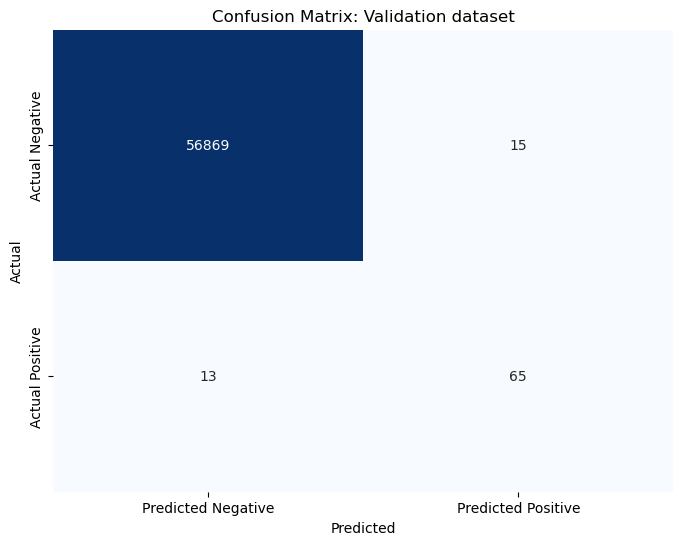

In [38]:
conf_val_matrix = confusion_matrix(y_val, y_pred_xgb)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_val_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Validation dataset')
plt.show()

# Hypertuning parameters

## Hyperparameter Tuning with Randomized Search

- Hyperparameters are defined in the `param_dist` dictionary, specifying ranges or distributions for various parameters such as the number of estimators, learning rate and maximum depth.
- The XGBoost classifier is initialized with a random state for reproducibility.
- RandomizedSearchCV is initialized with parameters such as the estimator (XGBoost classifier), parameter distributions (`param_dist`), number of iterations (`n_iter`), cross-validation folds (`cv`), scoring metric (`scoring`), and parallelization (`n_jobs`).
- The `fit()` method of RandomizedSearchCV is called, which explores the hyperparameter space and evaluates different combinations using cross-validation.
- After completion, the best combination of hyperparameters is obtained using the `best_params_` attribute.
- Finally, the best hyperparameters discovered through randomized search are printed for further use in model training.


In [50]:
# Define the parameter distributions for randomized search including regularization parameters
param_dist = {
    'n_estimators': randint(50, 150),           
    'learning_rate': uniform(0.01, 0.2 - 0.01), 
    'max_depth': randint(3, 7)       
    
}
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV with parallelization
random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Perform randomized search to find the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_random = random_search.best_params_
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)


Best Hyperparameters (RandomizedSearchCV): {'learning_rate': 0.16944503776222114, 'max_depth': 6, 'n_estimators': 126}


## Cross-Validation Scores

- The `cv_results_` attribute of the RandomizedSearchCV object contains detailed information about the cross-validation results.
- We extract the mean test scores from the `cv_results_` dictionary and print them to evaluate the performance of different hyperparameter combinations.
- Each mean test score represents the average accuracy achieved by the model during cross-validation for a particular set of hyperparameters.
- Analyzing these scores provides insights into the stability and consistency of the model's performance across different parameter combinations.


In [41]:
cv_results = random_search.cv_results_

# Extract and print all cross-validation scores
print("All Cross-Validation Scores:")
for mean_score in cv_results['mean_test_score']:
    print("Mean Accuracy:", mean_score)


All Cross-Validation Scores:
Mean Accuracy: 0.9958344807427915
Mean Accuracy: 0.998962284520869
Mean Accuracy: 0.9968458140054983
Mean Accuracy: 0.9968340887430662
Mean Accuracy: 0.998988667209918
Mean Accuracy: 0.9797733480652886
Mean Accuracy: 0.9950078272916419
Mean Accuracy: 0.994969718910502
Mean Accuracy: 0.9994928678021452
Mean Accuracy: 0.9994488970261013


# Training & Evaluating the model with best Hyperparameters

## Training Final Model with Best Hyperparameters


- The XGBoost classifier is initialized with the best hyperparameters obtained from the randomized search, including the number of estimators, learning rate and maximum depth.
- 0 These hyperparameters are crucial as they have been found to optimize the model's performance during the hyperparameter tuning process.
- The `fit()` method of the XGBoost classifier is called, passing the entire training dataset (`X_train` and `y_train`) as arguments.
- By training the model on the entire dataset, it leverages all available information to learn the underlying patterns in the data.
- Once trained, the final XGBoost classifier model is ready for evaluation and deployment on new unseen data.


In [51]:
# Initialize XGBoost classifier with best hyperparameters including regularization terms
best_xgb_classifier = xgb.XGBClassifier(n_estimators=best_params_random['n_estimators'],
                                        learning_rate=best_params_random['learning_rate'],
                                        max_depth=best_params_random['max_depth'],
                                        random_state=42)

# Train the final model on the entire training dataset
best_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16944503776222114,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=126, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Model Evaluation on Validation Data

After making predictions on the validation data using the final XGBoost classifier model, the following evaluation metrics were obtained:

 - Accuracy: 0.9995435553526912
 - Precision: 0.8333333333333334
 - Recall: 0.8333333333333334
 - F1-score: 0.8333333333333334

These metrics demonstrate the performance of the model in classifying instances on the validation data. A high accuracy, precision, recall, and F1-score indicate that the model performs well and exhibits a balanced trade-off between precision and recall.


In [52]:
# Predict on the validation data
y_pred_val = best_xgb_classifier.predict(X_val)

# Calculate accuracy, precision, recall, F1-score
accuracy_gb = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

print("xgboost Accuracy:", accuracy_gb)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


xgboost Accuracy: 0.9995259997893332
Precision: 0.8227848101265823
Recall: 0.8333333333333334
F1-score: 0.8280254777070064


# Model testing on test data

## Model Evaluation on Test Data

After applying the trained XGBoost classifier model to the test dataset, the following evaluation metrics were obtained:

 - Accuracy: 0.999420666409185
 - Precision: 0.8095238095238095
 - Recall: 0.8673469387755102
 - F1-score: 0.8374384236453202

These metrics provide insights into the performance of the model on unseen data. A high accuracy, precision, recall, and F1-score indicate that the model generalizes well and performs effectively on new instances, demonstrating its robustness and reliability.


In [54]:
# Model evaluation on test data
y_test_pred_gb = best_xgb_classifier.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
precision = precision_score(y_test, y_test_pred_gb)
recall = recall_score(y_test, y_test_pred_gb)
f1 = f1_score(y_test, y_test_pred_gb)
print("xgboost Accuracy:", accuracy_gb)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

xgboost Accuracy: 0.9995084442259752
Precision: 0.85
Recall: 0.8673469387755102
F1-score: 0.8585858585858585


## Confusion Matrix for Test Data


The confusion matrix summarizes the performance of the XGBoost classifier model on the test data:

 - True Positive (TP): Instances correctly predicted as positive.
 - True Negative (TN): Instances correctly predicted as negative.
 - False Positive (FP): Instances incorrectly predicted as positive.
 - False Negative (FN): Instances incorrectly predicted as negative.

The heatmap visualization provides a clear representation of the frequency of instances in each cell, aiding in the assessment of the model's strengths and weaknesses on the test data.



Confusion Matrix:


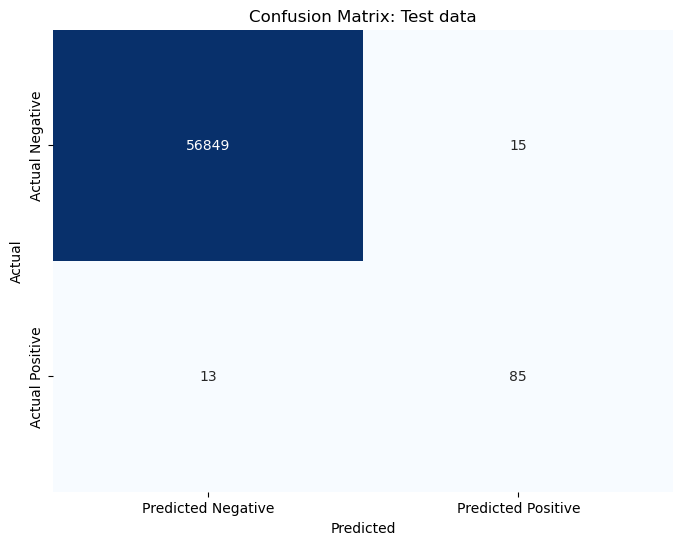

In [55]:
conf_test_matrix = confusion_matrix(y_test, y_test_pred_gb)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_test_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Test data')
plt.show()

# Model Export

Exporting a best_xgb_classifier using joblib

In [58]:
import joblib

joblib.dump(best_xgb_classifier, 'finddefault_xgb_model.pkl')

['finddefault_xgb_model.pkl']

In [63]:
import pickle

# Load the model from the file
model = joblib.load('finddefault_xgb_model.pkl')

model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16944503776222114,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=126, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Model deployment

## Saving Data in CSV Format


- The `to_csv()` function is used to save the training and validation datasets into CSV files.
- Parameters `index=False` and `header=False` are specified to exclude row and column indices, respectively, from the CSV files.
- This ensures that the CSV files only contain the data without additional metadata.
- The output column is expected to be the first column in each CSV file, as per the convention.
- Saving the data in CSV format facilitates easy storage, sharing, and processing of the datasets for subsequent tasks such as model training or analysis.



In [46]:
#Using 'csv' fprmat to store the data
# The first column is expected to be the ouput column

train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

KeyboardInterrupt: 

## Uploading Data to Amazon S3 and Listing Contents

The training and validation datasets are uploaded to an Amazon S3 bucket for storage and access within the SageMaker environment. Additionally, the contents of the S3 bucket are listed to verify the upload.

 - The code first retrieves the default S3 bucket associated with the SageMaker session using `sagemaker.Session().default_bucket()`.
 - A prefix named "find-default-xgboost-credit-fraud" is specified to organize the data within the bucket.
 - Using `boto3.Session().resource('s3').Bucket(bucket).Object()`, references to the S3 bucket and objects are created.
 - The `upload_file()` function is called to upload the local CSV files (`train.csv` and `validation.csv`) to the specified location in the S3 bucket.
 - Finally, the contents of the S3 bucket are listed recursively using the AWS CLI command `aws s3 ls`, showing the uploaded CSV files within the specified prefix.


In [ ]:
import sagemaker, boto3, os

bucket = sagemaker.Session().default_bucket()
prefix = "find-default-xgboost-credit-fraud"

boto3.Session().resource('s3').Bucket(bucket).Object(
        os.path.join(prefix,'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
        os.path.join(prefix,'data/validation.csv')).upload_file('validation.csv')

In [ ]:
! aws s3 ls {bucket}/{prefix}/data --recursive

# Creating an XGBoost Estimator for Training


- The output location for storing model artifacts after training is specified as an S3 path.
- The container image URI for XGBoost is retrieved based on the AWS region and XGBoost version.
- An `sagemaker.estimator.Estimator` object is created with parameters including image URI, IAM role ARN, instance configuration, output path, session object, and debugging rules.


In [ ]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

In [ ]:
sagemaker.__version__

## Setting Hyperparameters and Defining Training Inputs


- Hyperparameters such as the number of boosting rounds (`num_round`), learning rate (`learning_rate`), maximum depth of trees (`max_depth`)are set based on the best parameters obtained from the randomized search.
`sagemaker.session.TrainingInput` is used to define training inputs for the XGBoost model.
- Training data is specified with the S3 path to the training CSV file, along with the content type as CSV.
- Similarly, validation data is specified with the S3 path to the validation CSV file, along with the content type as CSV.


In [ ]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]

)

## Model Training and Retrieving Model Data


- The `fit()` method is called on the XGBoost estimator (`xgb_model`) to initiate the training process. It takes a dictionary where the keys are strings representing the input data channels ("train" for training data and "validation" for validation data) and the values are the corresponding `TrainingInput` objects. The `wait=True` argument ensures that the method waits until the training job completes before continuing.
 - Upon successful completion of the training job, the `model_data` attribute of the XGBoost estimator is accessed to retrieve the location of the trained model artifacts stored in Amazon S3. This information can be used for model deployment or further analysis.


In [ ]:
xgb_model.set_hyperparameters(
    num_round=best_params_random['n_estimators'],
    learning_rate=best_params_random['learning_rate'],
    max_depth=best_params_random['max_depth']
)

In [ ]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)


## Deploying XGBoost Model as an Endpoint

- The `deploy()` method is called on the XGBoost estimator (`xgb_model`) to deploy the trained model as an endpoint. It takes arguments such as `initial_instance_count` (the number of instances to deploy initially), `instance_type` (the type of instances to use), and `serializer` (the method for serializing input data for inference).
- In this case, the endpoint is configured with one instance of type `ml.t2.medium`, which is suitable for low-traffic or testing purposes.
- The `CSVSerializer()` is used to serialize input data in CSV format for inference.
- After successful deployment, the endpoint name is printed, which can be used to make predictions using the deployed model.



In [ ]:
xgb_model.fit({"train":train_input, "validation":validation_input}, wait=True)

In [ ]:
rule_ouput_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.name +"/rule-ouput"
! aws s3 ls {rule_output_path} --recursive

In [ ]:
! aws s3 cp {rule_ouput_path} ./ --recursive

In [ ]:
xgb_model.model_data

In [ ]:
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
   initial_instance_count=1,
   instance_type='ml.t2.medium',
   serializer=CSVSerializer()
)

In [ ]:
xgb_predictor.endpoint_name

## Making Predictions using the Deployed Endpoint and Evaluation


- The SageMaker runtime client (`sagemaker_runtime`) is initialized to interact with the deployed endpoint.
- The endpoint name is specified to identify the deployed XGBoost model endpoint.
- The code iterates through the test data, serializes each row as a CSV payload, and sends the payload to the endpoint for predictions using the `invoke_endpoint` method.
- Predictions returned by the endpoint are collected and evaluated using standard evaluation metrics such as accuracy, - - precision, recall, and F1-score.
- After evaluation, the endpoint is deleted using the SageMaker client (`sagemaker_client`) to avoid incurring additional costs.


In [ ]:
# Initialize the SageMaker runtime client
sagemaker_runtime = boto3.client('sagemaker-runtime')
# Specify the endpoint name
endpoint_name = xgb_predictor.endpoint_name  

In [ ]:
# Iterate through test data and invoke endpoint for predictions
predictions = []
for index, row in X_test.iterrows():
    payload = ','.join(map(str, row.values))
    response = sagemaker_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                                 ContentType='text/csv',
                                                 Body=payload)
    result = response['Body'].read().decode('utf-8')
    predictions.append(float(result.strip()))

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
# Delete the endpoint
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
print(f"Endpoint {endpoint_name} is successfully deleted.")